In [1]:
import numpy as np
from astropy.io import fits
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class ALMADiskClusterer:
    def __init__(self, directory, layers=[0], n_clusters=4, method='gmm', random_state=42):
        """
        Initialize the ALMA Disk clustering pipeline
        
        Args:
            directory: Path to directory containing FITS files
            layers: List of indices to extract from last dimension (default [0])
            n_clusters: Number of clusters to find
            method: Clustering method ('gmm', 'kmeans', or 'dbscan')
            random_state: Random seed for reproducibility
        """
        if not os.path.isdir(directory):
            raise ValueError(f"Directory not found: {directory}")
            
        self.directory = directory
        self.layers = layers
        self.n_clusters = n_clusters
        self.method = method
        self.random_state = random_state
        self.results = {}
        
    def load_data(self):
        """Load and preprocess FITS files from directory with error handling"""
        try:
            files = sorted([f for f in os.listdir(self.directory) 
                          if f.endswith('.fits') or f.endswith('.fits.gz')])
            
            if not files:
                raise ValueError(f"No FITS files found in {self.directory}")
                
            all_data = []
            valid_files = []
            
            for file in tqdm(files, desc="Loading FITS files"):
                try:
                    with fits.open(os.path.join(self.directory, file)) as hdul:
                        if len(hdul) == 0:
                            print(f"Warning: Empty FITS file {file} - skipping")
                            continue
                            
                        data_cube = hdul[0].data
                        
                        if data_cube is None:
                            print(f"Warning: No data in primary HDU of {file} - skipping")
                            continue
                            
                        # Extract selected layers and normalize
                        extracted_layers = []
                        for layer_idx in self.layers:
                            try:
                                layer_data = np.squeeze(data_cube[..., layer_idx])
                                if layer_data.size == 0:
                                    print(f"Warning: Empty layer {layer_idx} in {file} - skipping")
                                    continue
                                    
                                layer_data = (layer_data - np.min(layer_data)) / (np.max(layer_data) - np.min(layer_data))
                                extracted_layers.append(layer_data)
                            except IndexError as e:
                                print(f"Warning: {e} in {file} - skipping layer {layer_idx}")
                                continue
                        
                        if not extracted_layers:
                            print(f"Warning: No valid layers extracted from {file} - skipping")
                            continue
                            
                        stacked_data = np.stack(extracted_layers, axis=-1)
                        all_data.append(stacked_data)
                        valid_files.append(file)
                        
                except Exception as e:
                    print(f"Error processing {file}: {str(e)} - skipping")
                    continue
            
            if not all_data:
                raise ValueError("No valid data loaded from any files")
                
            self.results.update({
                'images': np.array(all_data),
                'filenames': valid_files,
                'original_shapes': [img.shape for img in all_data]
            })
            
        except Exception as e:
            raise RuntimeError(f"Data loading failed: {str(e)}")
    
    def extract_features(self):
        """Extract meaningful features from disk images with validation"""
        if 'images' not in self.results:
            raise RuntimeError("Must load data before feature extraction")
            
        image_data = self.results['images']
        
        if len(image_data) == 0:
            raise ValueError("No images available for feature extraction")
            
        all_features = []
        feature_names = []
        
        for file_idx in tqdm(range(image_data.shape[0]), desc="Extracting features"):
            file_features = []
            
            for layer_idx in range(len(self.layers)):
                try:
                    img = image_data[file_idx, :, :, layer_idx]
                    
                    # Skip if image is empty
                    if np.all(img == 0) or np.isnan(img).all():
                        print(f"Warning: Empty image at file {file_idx}, layer {layer_idx}")
                        file_features.extend([0] * 7)  # Pad with zeros
                        continue
                        
                    # Basic statistics
                    mean_val = np.mean(img)
                    std_val = np.std(img)
                    max_val = np.max(img)
                    file_features.extend([mean_val, std_val, max_val])
                    
                    # Radial profile features
                    center = np.array(img.shape) // 2
                    y, x = np.indices(img.shape)
                    r = np.sqrt((x - center[1])**2 + (y - center[0])**2).astype(int)
                    radial_profile = np.bincount(r.ravel(), img.ravel()) / np.bincount(r.ravel())
                    
                    radial_std = np.std(radial_profile)
                    radial_gradient = np.mean(np.diff(radial_profile[:50]))
                    file_features.extend([radial_std, radial_gradient])
                    
                    # Asymmetry features
                    rotated = np.rot90(img, 2)
                    asymmetry = np.mean(np.abs(img - rotated))
                    file_features.append(asymmetry)
                    
                    # Concentration index
                    total_flux = np.sum(img)
                    half_flux = total_flux / 2
                    cumulative = np.cumsum(np.sort(img.ravel())[::-1])
                    concentration = np.where(cumulative >= half_flux)[0][0] / len(cumulative)
                    file_features.append(concentration)
                    
                    # Add feature names (only once)
                    if file_idx == 0:
                        prefix = f"L{self.layers[layer_idx]}_"
                        feature_names.extend([
                            prefix + "mean", prefix + "std", prefix + "max",
                            prefix + "radial_std", prefix + "radial_grad",
                            prefix + "asymmetry", prefix + "concentration"
                        ])
                
                except Exception as e:
                    print(f"Error extracting features from file {file_idx}, layer {layer_idx}: {str(e)}")
                    file_features.extend([0] * 7)  # Pad with zeros
                    continue
            
            # Cross-layer features if multiple layers
            if len(self.layers) > 1:
                try:
                    ratio = image_data[file_idx, :, :, 0] / (image_data[file_idx, :, :, 1] + 1e-10)
                    ratio_feat = [np.mean(ratio), np.std(ratio)]
                    file_features.extend(ratio_feat)
                    
                    if file_idx == 0:
                        feature_names.extend(["ratio_mean", "ratio_std"])
                except:
                    file_features.extend([0, 0])  # Pad with zeros
            
            all_features.append(file_features)
        
        self.results.update({
            'features': np.array(all_features),
            'feature_names': feature_names
        })
    
    def reduce_dimensions(self):
        """Perform dimensionality reduction on features with validation"""
        if 'features' not in self.results:
            raise RuntimeError("Must extract features before dimensionality reduction")
            
        features = self.results['features']
        
        if len(features) == 0:
            raise ValueError("No features available for dimensionality reduction")
            
        try:
            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(features)
            
            pca = PCA(n_components=min(10, features.shape[1]))
            pca_features = pca.fit_transform(features_scaled)
            
            tsne = TSNE(n_components=2, perplexity=min(30, len(features)-1), 
                      random_state=self.random_state)
            reduced_features = tsne.fit_transform(pca_features)
            
            self.results.update({
                'reduced_features': reduced_features,
                'pca': pca,
                'tsne': tsne
            })
        except Exception as e:
            raise RuntimeError(f"Dimensionality reduction failed: {str(e)}")
    
    def cluster_data(self):
        """Perform clustering on reduced features with validation"""
        if 'reduced_features' not in self.results:
            raise RuntimeError("Must reduce dimensions before clustering")
            
        reduced_features = self.results['reduced_features']
        
        if len(reduced_features) == 0:
            raise ValueError("No data available for clustering")
            
        try:
            if self.method == 'gmm':
                clusterer = GaussianMixture(
                    n_components=min(self.n_clusters, len(reduced_features)),
                    random_state=self.random_state
                )
                labels = clusterer.fit_predict(reduced_features)
            elif self.method == 'kmeans':
                clusterer = KMeans(
                    n_clusters=min(self.n_clusters, len(reduced_features)),
                    random_state=self.random_state
                )
                labels = clusterer.fit_predict(reduced_features)
            elif self.method == 'dbscan':
                clusterer = DBSCAN(eps=0.5, min_samples=min(5, len(reduced_features)//2))
                labels = clusterer.fit_predict(reduced_features)
            else:
                raise ValueError(f"Unknown clustering method: {self.method}")
            
            self.results.update({
                'labels': labels,
                'clusterer': clusterer
            })
        except Exception as e:
            raise RuntimeError(f"Clustering failed: {str(e)}")
    
    def visualize_results(self, n_samples=3):
        """Visualize clustering results with validation"""
        if 'labels' not in self.results or 'images' not in self.results:
            raise RuntimeError("Must complete clustering before visualization")
            
        labels = self.results['labels']
        images = self.results['images']
        
        if len(labels) == 0 or len(images) == 0:
            raise ValueError("No data available for visualization")
            
        # Cluster scatter plot
        plt.figure(figsize=(10, 8))
        sns.scatterplot(x=self.results['reduced_features'][:, 0], 
                       y=self.results['reduced_features'][:, 1], 
                       hue=labels, palette='viridis', s=100)
        plt.title(f"Clustering Results ({self.method.upper()}, {len(np.unique(labels))} clusters)")
        plt.xlabel("t-SNE 1")
        plt.ylabel("t-SNE 2")
        plt.show()
        
        # Sample images from each cluster
        unique_labels = np.unique(labels)
        
        fig, axs = plt.subplots(len(unique_labels), n_samples + 1, 
                              figsize=(15, 3*len(unique_labels)),
                              squeeze=False)
        
        for i, label in enumerate(unique_labels):
            # Cluster info header
            axs[i, 0].text(0.5, 0.5, 
                          f"Cluster {label}\n"
                          f"N={np.sum(labels == label)}\n",
                          ha='center', va='center')
            axs[i, 0].axis('off')
            
            # Sample images
            cluster_indices = np.where(labels == label)[0]
            for j in range(min(n_samples, len(cluster_indices))):
                img_idx = cluster_indices[j]
                img = images[img_idx, :, :, 0]  # First layer
                axs[i, j+1].imshow(img, cmap='inferno', origin='lower')
                axs[i, j+1].set_title(self.results['filenames'][img_idx])
                axs[i, j+1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    def run_pipeline(self):
        """Execute complete clustering pipeline with error handling"""
        try:
            print("Loading data...")
            self.load_data()
            print(f"Successfully loaded {len(self.results['filenames'])} files")
            
            print("Extracting features...")
            self.extract_features()
            print(f"Extracted {len(self.results['feature_names'])} features")
            
            print("Reducing dimensions...")
            self.reduce_dimensions()
            print("Dimensionality reduction complete")
            
            print("Clustering data...")
            self.cluster_data()
            print(f"Found {len(np.unique(self.results['labels']))} clusters")
            
            print("Visualizing results...")
            self.visualize_results()
            
            return self.results
            
        except Exception as e:
            print(f"Pipeline failed: {str(e)}")
            raise

Loading data...


Loading FITS files:   0%|                               | 0/150 [00:00<?, ?it/s]/var/folders/g1/pdsb5q1j5k1fd8sr26nv9pqh0000gn/T/ipykernel_55355/1569423124.py:57: RuntimeWarning: invalid value encountered in true_divide
  layer_data = (layer_data - np.min(layer_data)) / (np.max(layer_data) - np.min(layer_data))
Loading FITS files: 100%|█████████████████████| 150/150 [00:10<00:00, 14.38it/s]


Successfully loaded 150 files
Extracting features...


Extracting features: 100%|██████████████████| 150/150 [00:00<00:00, 3276.48it/s]
/Users/pratibhanaik/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/pratibhanaik/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Extracted 7 features
Reducing dimensions...
Dimensionality reduction complete
Clustering data...
Found 5 clusters
Visualizing results...


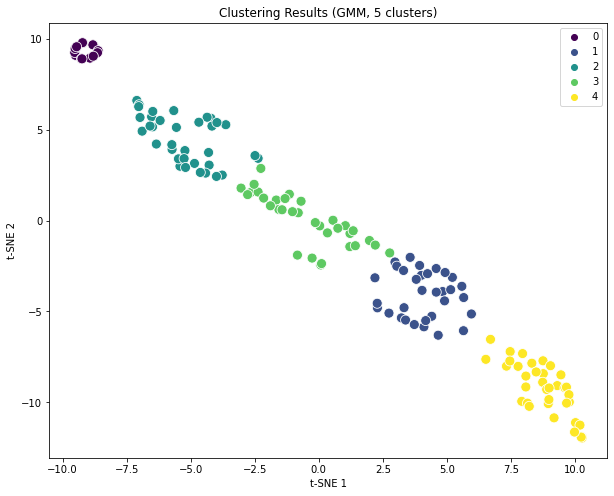

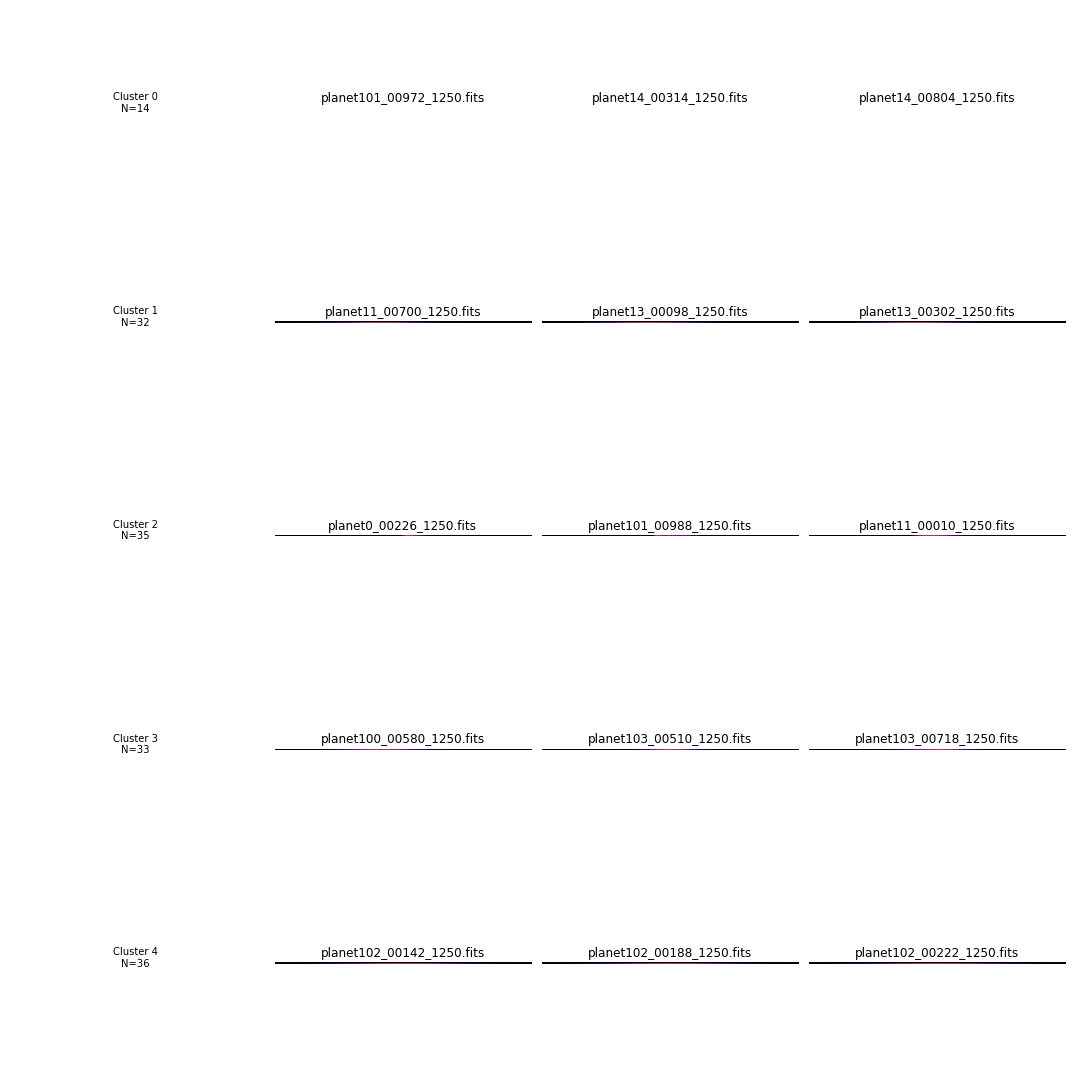


Cluster distribution:
[14 32 35 33 36]


In [3]:
if __name__ == "__main__":
    try:
        clusterer = ALMADiskClusterer(
            directory="ALMA observatory images",
            layers=[0],  # Use first layer only
            n_clusters=5,  # Number of expected clusters
            method='gmm',  # Clustering method
            random_state=42
        )
        
        results = clusterer.run_pipeline()
        
        # Access results
        print("\nCluster distribution:")
        print(np.bincount(results['labels'] + np.min(results['labels'])))
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")